In [21]:
# Original script credit goes to Hunter Kempf
# https://www.kaggle.com/code/huntingdata11/plotly-animated-and-interactive-nfl-plays/input

import numpy as np
import pandas as pd
import polars as pl
import glob

In [46]:
# read all data
players = pl.read_parquet('../Data/players.parquet')
plays = pl.read_parquet('../Data/plays.parquet')
games = pl.read_parquet('../Data/games.parquet')
tracking = pl.read_parquet('../Data/tracking_week_*.parquet')

# normalize orientation 'o' and direction 'dir'
# convert 'NA' to 0
replacement_values = {'NA': '0'}
tracking = tracking.with_columns(
    pl.col('o').apply(lambda x: replacement_values.get(x, x)),
)

tracking=tracking.with_columns([
    pl.when(pl.col('playDirection')=='right').then(pl.col('o').cast(pl.Float64)).otherwise((180+pl.col('o').cast(pl.Float64))%360).alias('firstAdjustedO'),
])

tracking=tracking.with_columns([
    pl.when(pl.col('firstAdjustedO') <= 180).then(180-pl.col('firstAdjustedO')).otherwise(540-pl.col('firstAdjustedO')).alias('adjustedO')
])

tracking=tracking.with_columns([
    pl.when(pl.col('playDirection')=='right').then(53.3-pl.col('y')).otherwise(pl.col('y')).alias('x'),
    pl.when(pl.col('playDirection')=='right').then(pl.col('x')).otherwise(120-pl.col('x')).alias('y')
])

players = players.with_columns([pl.col('nflId').cast(pl.Utf8)])


In [41]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go

# for mpl animation
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')

In [42]:
colors = {
    'ARI':["#97233F","#000000","#FFB612"], 
    'ATL':["#A71930","#000000","#A5ACAF"], 
    'BAL':["#241773","#000000"], 
    'BUF':["#00338D","#C60C30"], 
    'CAR':["#0085CA","#101820","#BFC0BF"], 
    'CHI':["#0B162A","#C83803"], 
    'CIN':["#FB4F14","#000000"], 
    'CLE':["#311D00","#FF3C00"], 
    'DAL':["#003594","#041E42","#869397"],
    'DEN':["#FB4F14","#002244"], 
    'DET':["#0076B6","#B0B7BC","#000000"], 
    'GB' :["#203731","#FFB612"], 
    'HOU':["#03202F","#A71930"], 
    'IND':["#002C5F","#A2AAAD"], 
    'JAX':["#101820","#D7A22A","#9F792C"], 
    'KC' :["#E31837","#FFB81C"], 
    'LA' :["#003594","#FFA300","#FF8200"], 
    'LAC':["#0080C6","#FFC20E","#FFFFFF"], 
    'LV' :["#000000","#A5ACAF"],
    'MIA':["#008E97","#FC4C02","#005778"], 
    'MIN':["#4F2683","#FFC62F"], 
    'NE' :["#002244","#C60C30","#B0B7BC"], 
    'NO' :["#101820","#D3BC8D"], 
    'NYG':["#0B2265","#A71930","#A5ACAF"], 
    'NYJ':["#125740","#000000","#FFFFFF"], 
    'PHI':["#004C54","#A5ACAF","#ACC0C6"], 
    'PIT':["#FFB612","#101820"], 
    'SEA':["#002244","#69BE28","#A5ACAF"], 
    'SF' :["#AA0000","#B3995D"],
    'TB' :["#D50A0A","#FF7900","#0A0A08"], 
    'TEN':["#0C2340","#4B92DB","#C8102E"], 
    'WAS':["#5A1414","#FFB612"], 
    'football':["#CBB67C","#663831"]
}

def hex_to_rgb_array(hex_color):
    '''take in hex val and return rgb np array'''
    return np.array(tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))) 

def ColorDistance(hex1,hex2):
    '''d = {} distance between two colors(3)'''
    if hex1 == hex2:
        return 0
    rgb1 = hex_to_rgb_array(hex1)
    rgb2 = hex_to_rgb_array(hex2)
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = abs(sum((2+rm,4,3-rm)*(rgb1-rgb2)**2))**0.5
    return d

def ColorPairs(team1,team2):
    color_array_1 = colors[team1]
    color_array_2 = colors[team2]

    # If color distance is small enough then flip color order
    if ColorDistance(color_array_1[0],color_array_2[0])<500:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[1],color_array_2[0]],'football':colors['football']}
    else:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[0],color_array_2[1]],'football':colors['football']}

In [61]:
def animate_play(games,tracking_df,play_df,players,gameId,playId, highlighted_players = []):
    selected_game_df = games[games.gameId==gameId].copy()
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    
    # get good color combos
    team_combos = list(set(selected_tracking_df.club.unique())-set(["football"]))
    
    color_orders = ColorPairs(team_combos[0],team_combos[1])
    
    # get play General information 
    line_of_scrimmage = np.where(selected_tracking_df.playDirection.values[0] == "right", selected_play_df.absoluteYardlineNumber.values[0], 120 - selected_play_df.absoluteYardlineNumber.values[0])
    
    ## Fixing first down marker issue from last year
    if selected_tracking_df.playDirection.values[0] == "right":
        first_down_marker = line_of_scrimmage - selected_play_df.yardsToGo.values[0]
    else:
        first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 10, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                y=np.arange(20,110,10), 
                x=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                y=np.arange(20,110,10), 
                x=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                y=[line_of_scrimmage,line_of_scrimmage], 
                x=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # # Add First down line 
        # data.append(
        #     go.Scatter(
        #         y=[first_down_marker,first_down_marker], 
        #         x=[0,53.5],
        #         line_dash='dash',
        #         line_color='yellow',
        #         showlegend=False,
        #         hoverinfo='none'
        #     )
        # )
        # Add Endzone Colors 
        endzoneColors = {0:color_orders[selected_game_df.homeTeamAbbr.values[0]][0],
                         110:color_orders[selected_game_df.visitorTeamAbbr.values[0]][0]}
        for x_min in [0,110]:
            data.append(
                go.Scatter(
                    y=[x_min,x_min,x_min+10,x_min+10,x_min],
                    x=[0,53.5,53.5,0,0],
                    fill="toself",
                    fillcolor=endzoneColors[x_min],
                    mode="lines",
                    line=dict(
                        color="white",
                        width=3
                        ),
                    opacity=1,
                    showlegend= False,
                    hoverinfo ="skip"
                )
            )
        # Plot Players
        # Note: references to "x" and "y" are using "adjustedX" and "adjustedY"
        for team in selected_tracking_df.club.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.club==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]

                    if selected_player_df.jerseyNumber.values[0] in highlighted_players:
                        vision_cone = get_vision_cone_coordinates(selected_player_df)
                        data.append(go.Scatter(
                            x=vision_cone[0], y=vision_cone[1], mode='lines', line_shape='spline', fill='toself',  # Fill the area inside the polygon
                            fillcolor='rgba(255,255,153,0.6)', line=dict(color='rgba(255,255,153,0)', width=2), showlegend=False)
                        )
                        data.append(go.Scatter(
                            x=vision_cone[2], y=vision_cone[3], mode='lines', line_shape='spline', fill='toself',  # Fill the area inside the polygon
                            fillcolor='rgba(255,255,153,0.6)', line=dict(color='rgba(255,255,153,0)', width=2), showlegend=False)
                        )
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker=go.scatter.Marker(
                                                                                             color=color_orders[team][0],
                                                                                             line=go.scatter.marker.Line(width=2,
                                                                                                            color=color_orders[team][1]),
                                                                                             size=10),
                                        name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker=go.scatter.Marker(
                                                                                             color=color_orders[team][0],
                                                                                             line=go.scatter.marker.Line(width=2,
                                                                                                            color=color_orders[team][1]),
                                                                                             size=10),
                                        name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        height=120*scale,
        width=60*scale,
        yaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        xaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # # Create First Down Markers 
    # for y_val in [0,53]:
    #     fig.add_annotation(
    #             y=first_down_marker,
    #             x=y_val,
    #             text=str(down),
    #             showarrow=False,
    #             font=dict(
    #                 family="Courier New, monospace",
    #                 size=16,
    #                 color="black"
    #                 ),
    #             align="center",
    #             bordercolor="black",
    #             borderwidth=2,
    #             borderpad=4,
    #             bgcolor="#ff7f0e",
    #             opacity=1
    #             )
    
    # Add Team Abbreviations in EndZone's
    for y_min in [0,110]:
        if y_min == 0:
            teamName=selected_game_df.homeTeamAbbr.values[0]
        else:
            teamName=selected_game_df.visitorTeamAbbr.values[0]
            
        fig.add_annotation(
            y=y_min+5,
            x=53.5/2,
            text=teamName,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=32,
                color="White"
                ),
            textangle = 0
        )
        
    buffer = 15
    fb = selected_tracking_df[selected_tracking_df['club']=='football']
    origin_fb_loc = fb.iloc[0]

    max_diff = 0
    if (abs(fb['x'].max()-origin_fb_loc['x']) > abs(fb['x'].min()-origin_fb_loc['x'])):
        max_dff = abs(fb['x'].max()-origin_fb_loc['x'])
    else:
        max_diff = abs(fb['x'].min()-origin_fb_loc['x'])
    return fig

def get_vision_cone_coordinates(player):
    import math
    DIST = 3
    DIST_MULTIPLIER = .95
    ANGLE = 22.5

    player_x = player['x'].iloc[0]
    player_y = player['y'].iloc[0]
    player_orientation = float(player['adjustedO'].iloc[0])

    # bad design but it's ok for now
    x_values = []
    y_values = []
    
    x1_values = []
    y1_values = []
    
    x1 = player_x + (DIST) * math.cos(math.radians(player_orientation+ANGLE))
    y1 = player_y + (DIST) * math.sin(math.radians(player_orientation+ANGLE))

    x2 = player_x + (DIST) * math.cos(math.radians(player_orientation-ANGLE))
    y2 = player_y + (DIST) * math.sin(math.radians(player_orientation-ANGLE))

    x1_with_multiplier = player_x + (DIST*DIST_MULTIPLIER) * math.cos(math.radians(player_orientation+ANGLE))
    y1_with_multiplier = player_y + (DIST*DIST_MULTIPLIER) * math.sin(math.radians(player_orientation+ANGLE))
    x2_with_multiplier = player_x + (DIST*DIST_MULTIPLIER) * math.cos(math.radians(player_orientation+ANGLE))
    y2_with_multiplier = player_y + (DIST*DIST_MULTIPLIER) * math.sin(math.radians(player_orientation+ANGLE))

    x1 = player_x + (DIST*DIST_MULTIPLIER) * math.cos(math.radians(player_orientation+ANGLE))
    y1 = player_y + (DIST*DIST_MULTIPLIER) * math.sin(math.radians(player_orientation+ANGLE))

    x3 = player_x + (DIST) * math.cos(math.radians(player_orientation))
    y3 = player_y + (DIST) * math.sin(math.radians(player_orientation))

    # print("hyp1: ", high_on_potenuse, " player_orientation: ", player_orientation)
    # print("player_x ", player_x, " player_y ", player_y)
    # print("x1: ", x1, " y1: ", y1)
    # print("x2: ", x2, " y2: ", y2)

    x_values.append(x1)
    y_values.append(y1)

    x_values.append(x3)
    y_values.append(y3)
    
    x_values.append(x2)
    y_values.append(y2)

    x1_values.append(x1)
    y1_values.append(y1)
    x1_values.append(player_x)
    y1_values.append(player_y)
    x1_values.append(x2)
    y1_values.append(y2)

    # print("player: ", player_x, ", ", player_y)
    # print(x3_values)
    # print(y3_values)
    
    return (x_values, y_values, x1_values, y1_values)

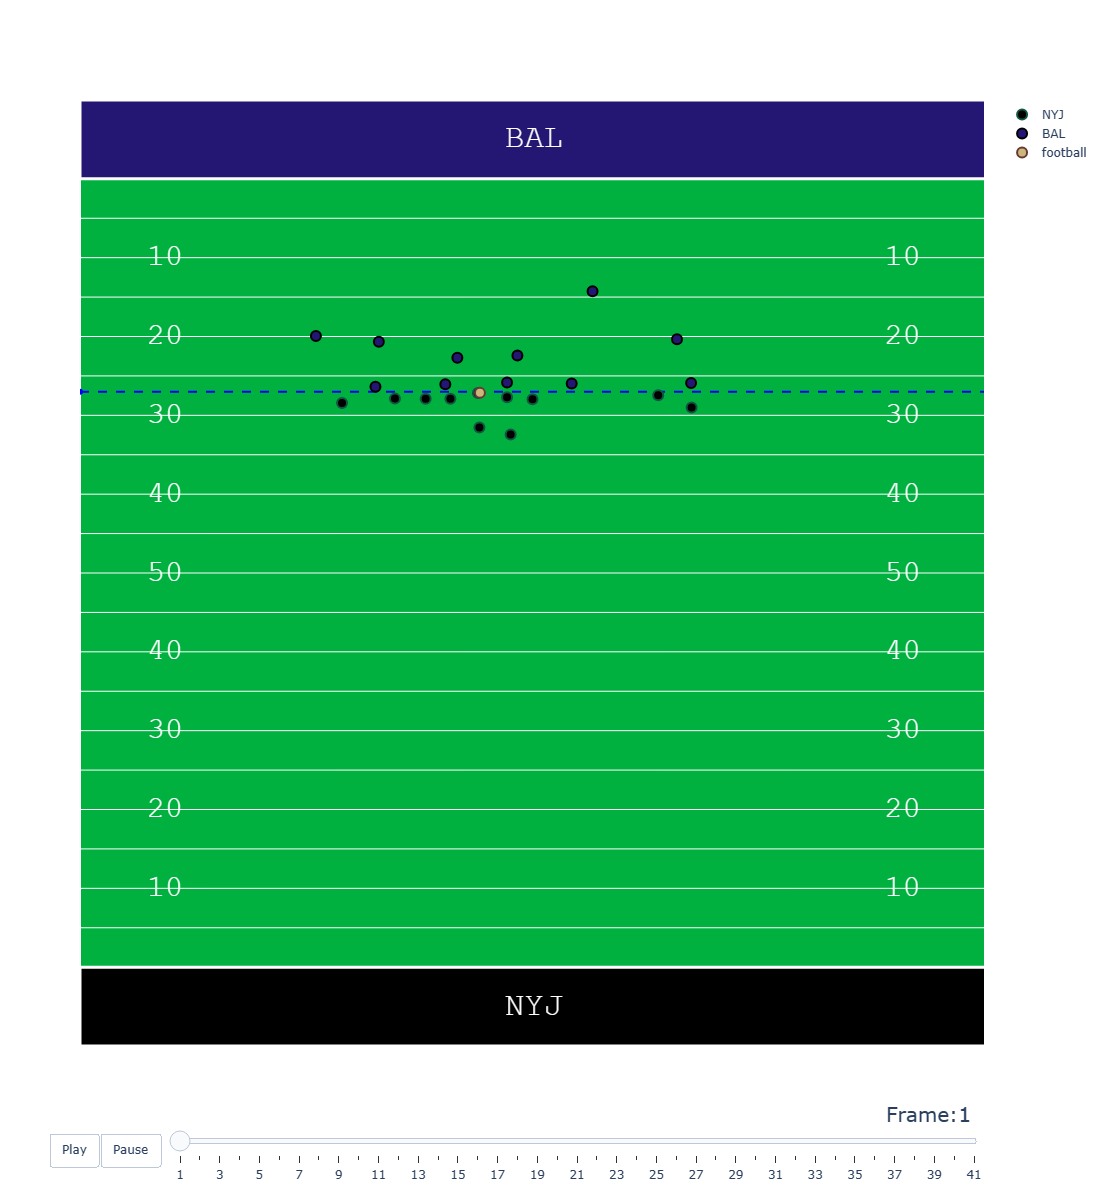

In [62]:
from plotly.offline import plot
animate_play(games.to_pandas(), tracking.to_pandas(), plays.to_pandas(), players.to_pandas(), 2022091107, 1841, [75, 50])